In [52]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
import itertools
import psutil
import copy
import math
import os
from tqdm import tqdm

In [53]:
def read_tsp_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Tìm vị trí bắt đầu của dữ liệu
    start_index = lines.index("EDGE_WEIGHT_SECTION\n") + 1
    
    # Đọc ma trận khoảng cách (định dạng LOWER_DIAG_ROW)
    distance_data = []
    for i in range(start_index, len(lines)):
        if lines[i].strip() == "EOF":
            break
        values = [int(val) for val in lines[i].strip().split()]
        distance_data.extend(values)
    
    # Đọc số lượng thành phố
    for line in lines:
        if "DIMENSION" in line:
            num_cities = int(line.split(":")[1].strip())
            break
    
    # Tạo ma trận khoảng cách đầy đủ
    distance_matrix = np.zeros((num_cities, num_cities))
    index = 0
    
    for i in range(num_cities):
        for j in range(i + 1):
            distance = distance_data[index]
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Ma trận đối xứng
            index += 1
    
    return distance_matrix


In [54]:
# Đọc dữ liệu từ file
file_path = "city.tsp"
distance_matrix = read_tsp_file(file_path)
print(f"Đã đọc ma trận khoảng cách cho {distance_matrix.shape[0]} thành phố.")
print("Ma trận khoảng cách:")
print(distance_matrix)


Đã đọc ma trận khoảng cách cho 10 thành phố.
Ma trận khoảng cách:
[[0. 2. 3. 6. 9. 3. 5. 7. 8. 4.]
 [2. 0. 4. 5. 7. 8. 6. 9. 3. 2.]
 [3. 4. 0. 8. 4. 6. 4. 3. 5. 6.]
 [6. 5. 8. 0. 6. 9. 8. 6. 4. 5.]
 [9. 7. 4. 6. 0. 7. 2. 1. 6. 3.]
 [3. 8. 6. 9. 7. 0. 3. 4. 2. 7.]
 [5. 6. 4. 8. 2. 3. 0. 5. 7. 4.]
 [7. 9. 3. 6. 1. 4. 5. 0. 3. 6.]
 [8. 3. 5. 4. 6. 2. 7. 3. 0. 2.]
 [4. 2. 6. 5. 3. 7. 4. 6. 2. 0.]]


In [55]:
def measure_performance(algorithm_func, *args):
    # Đo thời gian
    start_time = time.time()
    # Đo bộ nhớ trước khi chạy
    process = psutil.Process()
    memory_before = process.memory_info().rss
    
    # Chạy thuật toán
    result = algorithm_func(*args)
    
    # Đo bộ nhớ sau khi chạy
    memory_after = process.memory_info().rss
    memory_used = memory_after - memory_before
    
    # Thời gian chạy
    execution_time = time.time() - start_time
    
    return result, execution_time, memory_used

# Hàm tính tổng khoảng cách của một hành trình
def calculate_tour_distance(tour, distance_matrix):
    total_distance = 0
    num_cities = len(tour)
    
    for i in range(num_cities):
        j = (i + 1) % num_cities  # Quay lại thành phố đầu tiên
        total_distance += distance_matrix[tour[i], tour[j]]
    
    return total_distance


In [56]:
def greedy_algorithm(distance_matrix):
    num_cities = distance_matrix.shape[0]
    unvisited = set(range(1, num_cities))
    tour = [0]  # Bắt đầu từ thành phố 0
    
    # Lặp cho đến khi thăm tất cả các thành phố
    while unvisited:
        last_city = tour[-1]
        next_city = min(unvisited, key=lambda city: distance_matrix[last_city, city])
        tour.append(next_city)
        unvisited.remove(next_city)
    
    return tour

# Chạy thuật toán tham lam
greedy_tour, greedy_time, greedy_memory = measure_performance(greedy_algorithm, distance_matrix)
greedy_distance = calculate_tour_distance(greedy_tour, distance_matrix)

print(f"Thuật toán tham lam:")
print(f"Hành trình: {greedy_tour}")
print(f"Tổng khoảng cách: {greedy_distance}")
print(f"Thời gian thực hiện: {greedy_time:.6f} giây")
print(f"Bộ nhớ sử dụng: {greedy_memory / (1024 * 1024):.6f} MB")


Thuật toán tham lam:
Hành trình: [0, 1, 9, 8, 5, 6, 4, 7, 2, 3]
Tổng khoảng cách: 31.0
Thời gian thực hiện: 0.000999 giây
Bộ nhớ sử dụng: 0.000000 MB


In [57]:
def brute_force(distance_matrix):
    num_cities = distance_matrix.shape[0]
    cities = list(range(1, num_cities))  # Không bao gồm thành phố xuất phát (0)
    best_tour = None
    best_distance = float('inf')
    
    # Tạo tất cả các hoán vị có thể
    for perm in itertools.permutations(cities):
        tour = [0] + list(perm)  # Thêm thành phố xuất phát vào đầu hành trình
        distance = calculate_tour_distance(tour, distance_matrix)
        
        if distance < best_distance:
            best_distance = distance
            best_tour = tour
    
    return best_tour

# Chạy thuật toán vét cạn
brute_force_tour, brute_force_time, brute_force_memory = measure_performance(brute_force, distance_matrix)
brute_force_distance = calculate_tour_distance(brute_force_tour, distance_matrix)

print(f"Thuật toán vét cạn (Brute Force):")
print(f"Hành trình: {brute_force_tour}")
print(f"Tổng khoảng cách: {brute_force_distance}")
print(f"Thời gian thực hiện: {brute_force_time:.6f} giây")
print(f"Bộ nhớ sử dụng: {brute_force_memory / (1024 * 1024):.6f} MB")


Thuật toán vét cạn (Brute Force):
Hành trình: [0, 1, 9, 3, 8, 5, 6, 4, 7, 2]
Tổng khoảng cách: 27.0
Thời gian thực hiện: 2.513648 giây
Bộ nhớ sử dụng: 0.000000 MB


In [58]:
def mst_approximation(distance_matrix):
    num_cities = distance_matrix.shape[0]
    
    # Thuật toán Prim để xây dựng MST
    selected = [False] * num_cities
    selected[0] = True  # Bắt đầu từ thành phố 0
    mst_edges = []
    
    for _ in range(num_cities - 1):
        min_dist = float('inf')
        min_edge = None
        
        for i in range(num_cities):
            if selected[i]:
                for j in range(num_cities):
                    if not selected[j] and distance_matrix[i, j] < min_dist:
                        min_dist = distance_matrix[i, j]
                        min_edge = (i, j)
        
        if min_edge:
            u, v = min_edge
            selected[v] = True
            mst_edges.append((u, v))
    
    # Tạo đồ thị từ MST
    graph = [[] for _ in range(num_cities)]
    for u, v in mst_edges:
        graph[u].append(v)
        graph[v].append(u)
    
    # DFS để tìm hành trình
    visited = [False] * num_cities
    tour = []
    
    def dfs(node):
        visited[node] = True
        tour.append(node)
        for neighbor in graph[node]:
            if not visited[neighbor]:
                dfs(neighbor)
    
    dfs(0)
    
    # Loại bỏ các thành phố trùng lặp để đảm bảo mỗi thành phố chỉ được thăm một lần
    unique_tour = []
    visited = [False] * num_cities
    
    for city in tour:
        if not visited[city]:
            unique_tour.append(city)
            visited[city] = True
    
    return unique_tour

# Chạy thuật toán xấp xỉ
mst_tour, mst_time, mst_memory = measure_performance(mst_approximation, distance_matrix)
mst_distance = calculate_tour_distance(mst_tour, distance_matrix)

print(f"Thuật toán xấp xỉ (MST-based):")
print(f"Hành trình: {mst_tour}")
print(f"Tổng khoảng cách: {mst_distance}")
print(f"Thời gian thực hiện: {mst_time:.6f} giây")
print(f"Bộ nhớ sử dụng: {mst_memory / (1024 * 1024):.6f} MB")


Thuật toán xấp xỉ (MST-based):
Hành trình: [0, 1, 9, 8, 5, 3, 2, 7, 4, 6]
Tổng khoảng cách: 36.0
Thời gian thực hiện: 0.000000 giây
Bộ nhớ sử dụng: 0.000000 MB


In [59]:
def ant_colony_optimization(distance_matrix, num_ants=10, num_iterations=100, alpha=1, beta=5, evaporation_rate=0.5, Q=100):
    num_cities = distance_matrix.shape[0]
    pheromone = np.ones((num_cities, num_cities)) * 0.1
    
    # Tính toán ma trận độ hấp dẫn (visibility)
    visibility = np.zeros((num_cities, num_cities))
    for i in range(num_cities):
        for j in range(num_cities):
            if i != j:
                visibility[i, j] = 1.0 / distance_matrix[i, j]
    
    best_tour = None
    best_distance = float('inf')
    
    for iteration in range(num_iterations):
        tours = []
        
        # Mỗi kiến xây dựng một hành trình
        for ant in range(num_ants):
            tour = [0]  # Bắt đầu từ thành phố 0
            unvisited = set(range(1, num_cities))
            
            # Xây dựng hành trình cho kiến
            while unvisited:
                current_city = tour[-1]
                probabilities = []
                
                for city in unvisited:
                    numerator = (pheromone[current_city, city] ** alpha) * (visibility[current_city, city] ** beta)
                    probabilities.append((city, numerator))
                
                total = sum(p[1] for p in probabilities)
                if total == 0:  # Tránh chia cho 0
                    next_city = random.choice(list(unvisited))
                else:
                    # Chọn thành phố tiếp theo dựa trên xác suất
                    r = random.random() * total
                    cumulative = 0
                    next_city = None
                    
                    for city, prob in probabilities:
                        cumulative += prob
                        if cumulative >= r:
                            next_city = city
                            break
                    
                    if next_city is None:  # Nếu không chọn được, lấy thành phố cuối cùng
                        next_city = probabilities[-1][0]
                
                tour.append(next_city)
                unvisited.remove(next_city)
            
            tours.append(tour)
            
            # Cập nhật best tour
            distance = calculate_tour_distance(tour, distance_matrix)
            if distance < best_distance:
                best_distance = distance
                best_tour = tour.copy()
        
        # Cập nhật pheromone
        pheromone *= (1 - evaporation_rate)  # Bay hơi
        
        for tour in tours:
            distance = calculate_tour_distance(tour, distance_matrix)
            for i in range(num_cities):
                j = (i + 1) % num_cities
                pheromone[tour[i], tour[j]] += Q / distance
                pheromone[tour[j], tour[i]] += Q / distance  # Ma trận đối xứng
    
    return best_tour

# Chạy thuật toán bầy kiến
ant_tour, ant_time, ant_memory = measure_performance(ant_colony_optimization, distance_matrix)
ant_distance = calculate_tour_distance(ant_tour, distance_matrix)

print(f"Thuật toán bầy kiến (Ant Colony Optimization):")
print(f"Hành trình: {ant_tour}")
print(f"Tổng khoảng cách: {ant_distance}")
print(f"Thời gian thực hiện: {ant_time:.6f} giây")
print(f"Bộ nhớ sử dụng: {ant_memory / (1024 * 1024):.6f} MB")


Thuật toán bầy kiến (Ant Colony Optimization):
Hành trình: [0, 1, 9, 4, 7, 2, 6, 5, 8, 3]
Tổng khoảng cách: 30.0
Thời gian thực hiện: 0.155621 giây
Bộ nhớ sử dụng: 0.000000 MB


In [60]:
def genetic_algorithm(distance_matrix, population_size=50, num_generations=200, mutation_rate=0.2):
    num_cities = distance_matrix.shape[0]
    
    # Tạo quần thể ban đầu
    population = []
    for _ in range(population_size):
        tour = [0] + random.sample(range(1, num_cities), num_cities - 1)
        population.append(tour)
    
    def calculate_fitness(tour):
        return 1.0 / calculate_tour_distance(tour, distance_matrix)
    
    # Chọn cá thể theo phương pháp bánh xe roulette
    def selection(population):
        fitnesses = [calculate_fitness(tour) for tour in population]
        total_fitness = sum(fitnesses)
        if total_fitness == 0:
            return random.choice(population)
        
        r = random.random() * total_fitness
        cumulative = 0
        for i, fitness in enumerate(fitnesses):
            cumulative += fitness
            if cumulative >= r:
                return population[i]
        
        return population[-1]
    
    # Lai ghép hai cá thể (Ordered Crossover)
    def crossover(parent1, parent2):
        size = len(parent1)
        if size <= 2:
            return parent1.copy()
        
        # Chọn hai điểm cắt
        start, end = sorted(random.sample(range(1, size), 2))
        
        # Tạo con từ phần giữa của parent1
        child = [-1] * size
        child[0] = 0  # Luôn bắt đầu từ thành phố 0
        
        # Sao chép phần giữa từ parent1
        for i in range(start, end + 1):
            child[i] = parent1[i]
        
        # Điền các phần tử còn lại từ parent2
        j = 1
        for i in range(1, size):
            if child[i] == -1:  # Nếu vị trí này chưa được điền
                while parent2[j] in child:  # Tìm thành phố tiếp theo chưa có trong child
                    j += 1
                    if j >= size:
                        j = 1
                child[i] = parent2[j]
                j += 1
                if j >= size:
                    j = 1
        
        return child
    
    # Đột biến (Swap Mutation)
    def mutation(tour):
        if random.random() < mutation_rate:
            i, j = random.sample(range(1, len(tour)), 2)  # Không đổi vị trí thành phố xuất phát
            tour[i], tour[j] = tour[j], tour[i]
        return tour
    
    best_tour = None
    best_distance = float('inf')
    
    # Tiến hóa qua các thế hệ
    for _ in range(num_generations):
        # Đánh giá quần thể hiện tại
        for tour in population:
            distance = calculate_tour_distance(tour, distance_matrix)
            if distance < best_distance:
                best_distance = distance
                best_tour = tour.copy()
        
        # Tạo quần thể mới
        new_population = []
        for _ in range(population_size):
            parent1 = selection(population)
            parent2 = selection(population)
            child = crossover(parent1, parent2)
            child = mutation(child)
            new_population.append(child)
        
        population = new_population
    
    return best_tour

# Chạy thuật toán di truyền
genetic_tour, genetic_time, genetic_memory = measure_performance(genetic_algorithm, distance_matrix)
genetic_distance = calculate_tour_distance(genetic_tour, distance_matrix)

print(f"Thuật toán di truyền (Genetic Algorithm):")
print(f"Hành trình: {genetic_tour}")
print(f"Tổng khoảng cách: {genetic_distance}")
print(f"Thời gian thực hiện: {genetic_time:.6f} giây")
print(f"Bộ nhớ sử dụng: {genetic_memory / (1024 * 1024):.6f} MB")


Thuật toán di truyền (Genetic Algorithm):
Hành trình: [0, 3, 9, 8, 5, 6, 4, 7, 2, 1]
Tổng khoảng cách: 30.0
Thời gian thực hiện: 6.484120 giây
Bộ nhớ sử dụng: 0.000000 MB


In [61]:
def nearest_neighbor(distance_matrix):
    num_cities = distance_matrix.shape[0]
    unvisited = set(range(1, num_cities))
    tour = [0]  # Bắt đầu từ thành phố 0
    
    while unvisited:
        current_city = tour[-1]
        nearest = min(unvisited, key=lambda city: distance_matrix[current_city, city])
        tour.append(nearest)
        unvisited.remove(nearest)
    
    return tour

# Chạy thuật toán láng giềng gần nhất
nn_tour, nn_time, nn_memory = measure_performance(nearest_neighbor, distance_matrix)
nn_distance = calculate_tour_distance(nn_tour, distance_matrix)

print(f"Thuật toán láng giềng gần nhất (Nearest Neighbor):")
print(f"Hành trình: {nn_tour}")
print(f"Tổng khoảng cách: {nn_distance}")
print(f"Thời gian thực hiện: {nn_time:.6f} giây")
print(f"Bộ nhớ sử dụng: {nn_memory / (1024 * 1024):.6f} MB")


Thuật toán láng giềng gần nhất (Nearest Neighbor):
Hành trình: [0, 1, 9, 8, 5, 6, 4, 7, 2, 3]
Tổng khoảng cách: 31.0
Thời gian thực hiện: 0.000999 giây
Bộ nhớ sử dụng: 0.000000 MB


In [62]:
results = [
    {
        "name": "Thuật toán tham lam",
        "tour": greedy_tour,
        "distance": greedy_distance,
        "time": greedy_time,
        "memory": greedy_memory / (1024 * 1024)  # Chuyển sang MB
    },
    {
        "name": "Thuật toán brute force",
        "tour": brute_force_tour,
        "distance": brute_force_distance,
        "time": brute_force_time,
        "memory": brute_force_memory / (1024 * 1024)
    },
    {
        "name": "Thuật toán xấp xỉ (MST)",
        "tour": mst_tour,
        "distance": mst_distance,
        "time": mst_time,
        "memory": mst_memory / (1024 * 1024)
    },
    {
        "name": "Thuật toán bầy kiến",
        "tour": ant_tour,
        "distance": ant_distance,
        "time": ant_time,
        "memory": ant_memory / (1024 * 1024)
    },
    {
        "name": "Thuật toán di truyền",
        "tour": genetic_tour,
        "distance": genetic_distance,
        "time": genetic_time,
        "memory": genetic_memory / (1024 * 1024)
    },
    {
        "name": "Thuật toán láng giềng gần nhất",
        "tour": nn_tour,
        "distance": nn_distance,
        "time": nn_time,
        "memory": nn_memory / (1024 * 1024)
    }
]

# Tạo bảng so sánh
print("Bảng so sánh kết quả của 6 thuật toán:")
print("=" * 100)
print(f"{'Thuật toán':<25} {'Hành trình':<30} {'Tổng khoảng cách':<20} {'Thời gian (s)':<15} {'Bộ nhớ (MB)':<15}")
print("-" * 100)

for result in results:
    print(f"{result['name']:<25} {str(result['tour']):<30} {result['distance']:<20.2f} {result['time']:<15.6f} {result['memory']:<15.6f}")



Bảng so sánh kết quả của 6 thuật toán:
Thuật toán                Hành trình                     Tổng khoảng cách     Thời gian (s)   Bộ nhớ (MB)    
----------------------------------------------------------------------------------------------------
Thuật toán tham lam       [0, 1, 9, 8, 5, 6, 4, 7, 2, 3] 31.00                0.000999        0.000000       
Thuật toán brute force    [0, 1, 9, 3, 8, 5, 6, 4, 7, 2] 27.00                2.513648        0.000000       
Thuật toán xấp xỉ (MST)   [0, 1, 9, 8, 5, 3, 2, 7, 4, 6] 36.00                0.000000        0.000000       
Thuật toán bầy kiến       [0, 1, 9, 4, 7, 2, 6, 5, 8, 3] 30.00                0.155621        0.000000       
Thuật toán di truyền      [0, 3, 9, 8, 5, 6, 4, 7, 2, 1] 30.00                6.484120        0.000000       
Thuật toán láng giềng gần nhất [0, 1, 9, 8, 5, 6, 4, 7, 2, 3] 31.00                0.000999        0.000000       


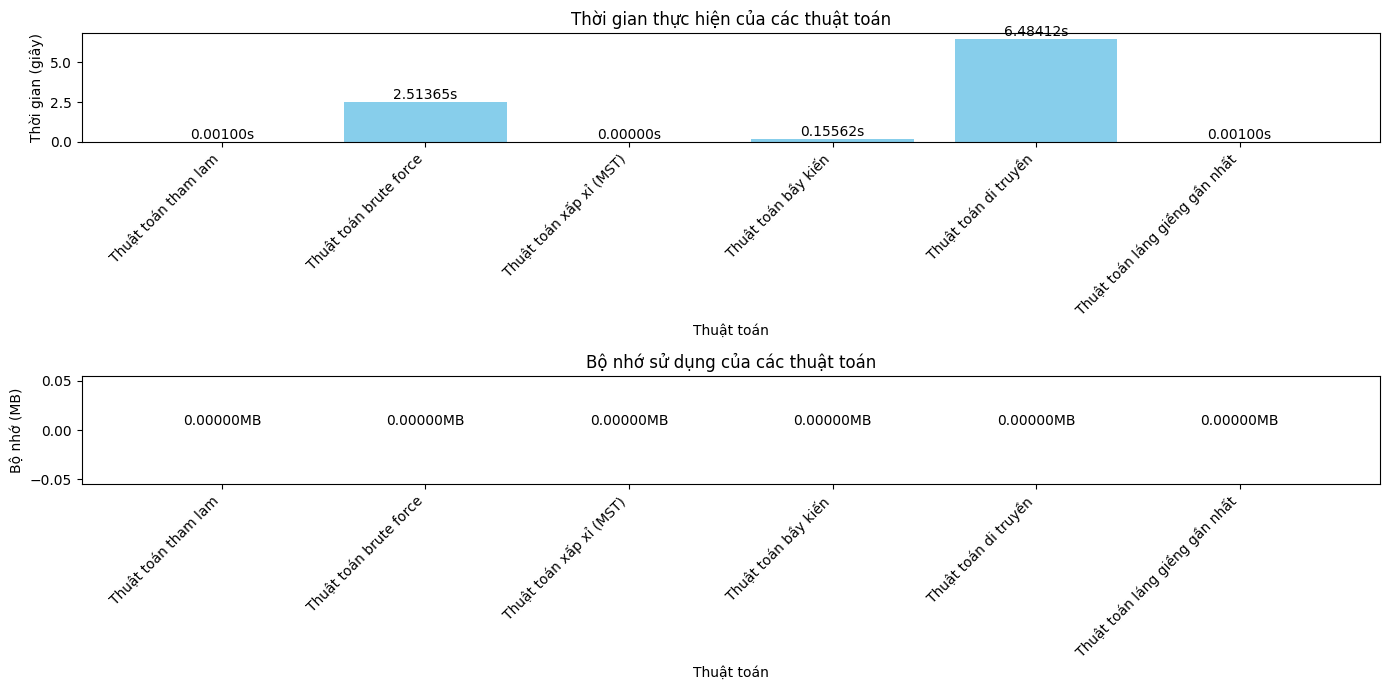

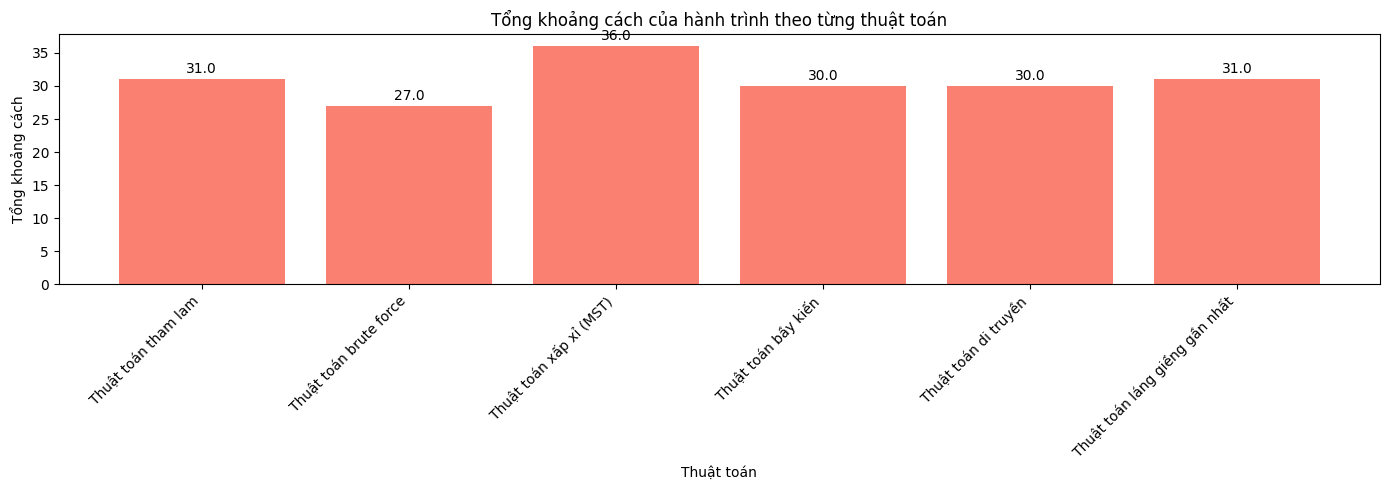

In [63]:
algorithm_names = [result["name"] for result in results]
execution_times = [result["time"] for result in results]
memory_usage = [result["memory"] for result in results]

# Vẽ biểu đồ thời gian
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
bars = plt.bar(algorithm_names, execution_times, color='skyblue')
plt.xlabel('Thuật toán')
plt.ylabel('Thời gian (giây)')
plt.title('Thời gian thực hiện của các thuật toán')
plt.xticks(rotation=45, ha='right')

# Thêm giá trị lên các cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.5f}s',
             ha='center', va='bottom', rotation=0)

# Vẽ biểu đồ bộ nhớ
plt.subplot(2, 1, 2)
bars = plt.bar(algorithm_names, memory_usage, color='lightgreen')
plt.xlabel('Thuật toán')
plt.ylabel('Bộ nhớ (MB)')
plt.title('Bộ nhớ sử dụng của các thuật toán')
plt.xticks(rotation=45, ha='right')

# Thêm giá trị lên các cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f'{height:.5f}MB',
             ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('tsp_algorithm_comparison.png')
plt.show()
plt.figure(figsize=(14, 5))
distances = [result["distance"] for result in results]
bars = plt.bar(algorithm_names, distances, color='salmon')
plt.xlabel('Thuật toán')
plt.ylabel('Tổng khoảng cách')
plt.title('Tổng khoảng cách của hành trình theo từng thuật toán')
plt.xticks(rotation=45, ha='right')

# Thêm giá trị lên các cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}',
             ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('tsp_distance_comparison.png')
plt.show()
